In [1]:
import scanpy as sc
import numpy as np
import pandas as pd
from tqdm import tqdm
import seaborn as sns
import squidpy as sq
from sklearn.preprocessing import StandardScaler
# from sklearn import model_selection
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt

# from scipy.spatial import cKDTree
# import nichepca as npc
# from xgboost import XGBRegressor
# import gensim
# from gensim.models import word2vec
# import wandb
# from utils import find_closest_points




/ictstr01/home/icb/eirini.giannakoulia/tools/apps/mamba/envs/mini/lib/python3.12/site-packages/anndata/utils.py:429: FutureWarning: Importing read_csv from `anndata` is deprecated. Import anndata.io.read_csv instead.
  warnings.warn(msg, FutureWarning)
/ictstr01/home/icb/eirini.giannakoulia/tools/apps/mamba/envs/mini/lib/python3.12/site-packages/anndata/utils.py:429: FutureWarning: Importing read_excel from `anndata` is deprecated. Import anndata.io.read_excel instead.
  warnings.warn(msg, FutureWarning)
/ictstr01/home/icb/eirini.giannakoulia/tools/apps/mamba/envs/mini/lib/python3.12/site-packages/anndata/utils.py:429: FutureWarning: Importing read_hdf from `anndata` is deprecated. Import anndata.io.read_hdf instead.
  warnings.warn(msg, FutureWarning)
/ictstr01/home/icb/eirini.giannakoulia/tools/apps/mamba/envs/mini/lib/python3.12/site-packages/anndata/utils.py:429: FutureWarning: Importing read_loom from `anndata` is deprecated. Import anndata.io.read_loom instead.
  warnings.warn(ms

In [2]:
#Set path to data
path_msi = "/lustre/groups/ml01/workspace/anastasia.litinetskaya/code/vitatrack/datasets/V11L12-038_A1.MSI_MOSCOT_paired_hvg.h5ad"
path_rna = "/lustre/groups/ml01/workspace/anastasia.litinetskaya/code/vitatrack/datasets/V11L12-038_A1.RNA_MOSCOT_paired_hvg.h5ad"

In [3]:
sc.read_h5ad(path_msi)

AnnData object with n_obs × n_vars = 2681 × 500
    obs: 'technology', 'clusters', 'split', 'og_index'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'clusters', 'clusters_colors', 'hvg', 'log1p', 'moranI', 'neighbors', 'pca', 'spatial_neighbors', 'umap'
    obsm: 'X_pca', 'X_umap', 'raw_counts', 'spatial', 'spatial_warp'
    varm: 'PCs'
    obsp: 'connectivities', 'distances', 'spatial_connectivities', 'spatial_distances'

In [4]:
adata_msi_full = sc.read_h5ad(path_msi)
adata_rna_full = sc.read_h5ad(path_rna)

### Prepare MSI data

In [5]:
adata_msi_full

AnnData object with n_obs × n_vars = 2681 × 500
    obs: 'technology', 'clusters', 'split', 'og_index'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'clusters', 'clusters_colors', 'hvg', 'log1p', 'moranI', 'neighbors', 'pca', 'spatial_neighbors', 'umap'
    obsm: 'X_pca', 'X_umap', 'raw_counts', 'spatial', 'spatial_warp'
    varm: 'PCs'
    obsp: 'connectivities', 'distances', 'spatial_connectivities', 'spatial_distances'

Here you can subset metabolites for noise  
e.g.:  
Remove m/z below FMP10, because most likely this is noise:  
```python
adata_msi_full.var_names  
adata_msi = adata_msi[:, adata_msi.var_names.astype(float) > 288.15].copy()

Identify common DHB matrix peaks and remove:


In [6]:
# adata_msi_full = sc.read_h5ad("your_file.h5ad")

# mz_values = np.array([float(mz) for mz in adata_msi_full.var_names])
# dhb_peaks_positive = np.array([137.0238, 155.0341, 177.0173, 193.0351, 273.0454])

# #Identify peaks to remove within ±0.1 m/z tolerance
# found_peaks = set(mz_values[np.any(np.abs(mz_values[:, None] - dhb_peaks_positive[None, :]) <= 0.1, axis=1)])

# # Convert found_peaks back to string format to match var_names
# found_peaks_str = set(map(str, found_peaks))

# # Create a mask to filter out DHB peaks
# keep_mask = ~adata_msi_full.var_names.isin(found_peaks_str)

# # Ensure both X and var are filtered consistently
# adata_msi = adata_msi_full[:, keep_mask].copy()
# adata_msi.var = adata_msi_full.var[keep_mask].copy()
# adata_msi.var_names_make_unique()


In [7]:
adata_msi = adata_msi_full.copy()

Quality control

In [8]:
sc.pp.calculate_qc_metrics(adata_msi, inplace=True)

<Axes: xlabel='total_counts', ylabel='Count'>

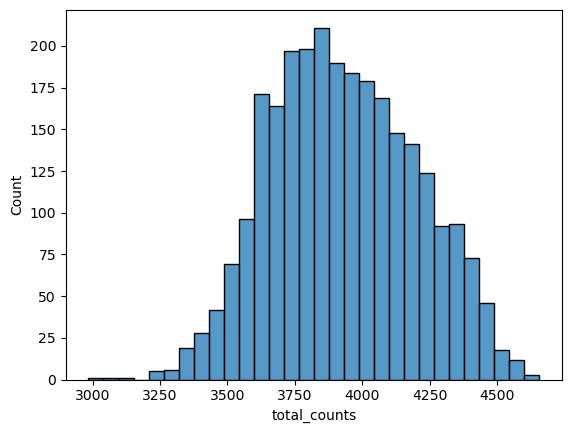

In [9]:
sns.histplot(adata_msi.obs.total_counts) #This sums all the metabolites m/z ratios for each cell

In [10]:
adata_msi.var

,highly_variable,means,dispersions,dispersions_norm,n_cells_by_counts,mean_counts,log1p_mean_counts,pct_dropout_by_counts,total_counts,log1p_total_counts
137.023795,True,16.457432,16.244787,1.111899,2681,16.832302,2.881012,0.000000,45127.400895,10.717267
154.026815,True,12.282051,12.890668,1.498388,2681,12.553079,2.606614,0.000000,33654.804196,10.423941
162.11293999999998,True,13.661283,13.783248,0.685038,2681,14.171650,2.719429,0.000000,37994.192488,10.545215
169.07619,True,13.470905,15.882873,5.257481,2681,13.721671,2.689321,0.000000,36787.800027,10.512949
169.076575,True,13.558031,15.862571,5.213268,2681,13.783150,2.693488,0.000000,36952.624199,10.517419
...,...,...,...,...,...,...,...,...,...,...
981.582135,True,8.348629,11.216965,0.650746,325,1.302877,0.834159,87.877658,3493.014565,8.158807
982.519885,True,8.086034,11.228839,0.684927,307,1.200151,0.788526,88.549049,3217.605359,8.076703
983.879985,True,8.370474,11.189914,0.572880,332,1.320715,0.841875,87.616561,3540.836599,8.172401
985.53971,True,7.986569,11.179927,0.625368,289,1.124553,0.753561,89.220440,3014.926453,8.011662


<Axes: xlabel='n_cells_by_counts', ylabel='Count'>

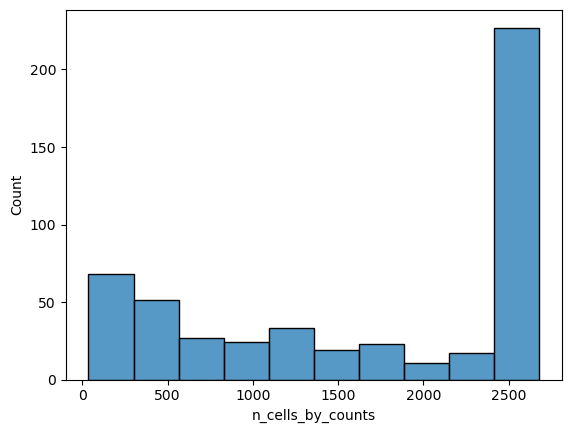

In [11]:
sns.histplot(adata_msi.var.n_cells_by_counts) #This sums all the cells for each metabolite m/z ratio
# we notice that o

In [12]:
adata_msi.var.n_cells_by_counts.describe()

count     500.00000
mean     1689.78800
std      1009.05623
min        36.00000
25%       634.50000
50%      1996.50000
75%      2678.00000
max      2681.00000
Name: n_cells_by_counts, dtype: float64

### Let's identify most spatialy variable metabolites

In [13]:
adata_msi

AnnData object with n_obs × n_vars = 2681 × 500
    obs: 'technology', 'clusters', 'split', 'og_index', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    uns: 'clusters', 'clusters_colors', 'hvg', 'log1p', 'moranI', 'neighbors', 'pca', 'spatial_neighbors', 'umap'
    obsm: 'X_pca', 'X_umap', 'raw_counts', 'spatial', 'spatial_warp'
    varm: 'PCs'
    obsp: 'connectivities', 'distances', 'spatial_connectivities', 'spatial_distances'

MoranI already present 

In [14]:
adata_msi.obsm['raw_counts']


array([[3.02383020e+07, 6.89276938e+05, 1.25918112e+06, ...,
        0.00000000e+00, 1.42000672e+05, 1.53159234e+05],
       [2.68674480e+07, 4.01469031e+05, 2.34221300e+06, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [2.53259560e+07, 4.05063688e+05, 6.53341938e+05, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       ...,
       [2.49772080e+07, 3.97291281e+05, 9.26245188e+05, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [1.87810580e+07, 2.47767078e+05, 1.27719200e+06, ...,
        9.26309473e+03, 0.00000000e+00, 0.00000000e+00],
       [2.75365420e+07, 3.55771500e+05, 8.48424875e+05, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00]])

In [15]:
adata_msi.obsm["spatial"]

array([[ 0, 49],
       [ 0, 50],
       [ 0, 51],
       ...,
       [62, 21],
       [62, 22],
       [62, 23]])

In [16]:
adata_msi.obsm["spatial_warp"]

array([[ 0., 49.],
       [ 0., 50.],
       [ 0., 51.],
       ...,
       [62., 21.],
       [62., 22.],
       [62., 23.]])

In [17]:
# Identify top 5 most spatially variable metabolomes using Moran's I
sq.gr.spatial_neighbors(adata_msi, spatial_key='spatial_warp')
sq.gr.spatial_autocorr(adata_msi)


In [18]:
adata_msi

AnnData object with n_obs × n_vars = 2681 × 500
    obs: 'technology', 'clusters', 'split', 'og_index', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    uns: 'clusters', 'clusters_colors', 'hvg', 'log1p', 'moranI', 'neighbors', 'pca', 'spatial_neighbors', 'umap'
    obsm: 'X_pca', 'X_umap', 'raw_counts', 'spatial', 'spatial_warp'
    varm: 'PCs'
    obsp: 'connectivities', 'distances', 'spatial_connectivities', 'spatial_distances'

In [19]:
adata_msi.uns["moranI"].loc[adata_msi.uns["moranI"].pval_norm_fdr_bh < 0.05].sort_index()

,I,pval_norm,var_norm,pval_norm_fdr_bh
137.023795,0.089212,0.000000e+00,0.000113,0.000000e+00
154.026815,0.075130,6.493694e-13,0.000113,9.094810e-13
162.11293999999998,0.720096,0.000000e+00,0.000113,0.000000e+00
169.07619,0.459921,0.000000e+00,0.000113,0.000000e+00
169.076575,0.459594,0.000000e+00,0.000113,0.000000e+00
...,...,...,...,...
967.552545,0.189479,0.000000e+00,0.000113,0.000000e+00
967.92917,0.046862,4.533976e-06,0.000113,5.827733e-06
968.5382649999999,0.036345,2.801393e-04,0.000113,3.424686e-04
968.564535,0.049012,1.739536e-06,0.000113,2.265021e-06


In [20]:
adata_msi.uns["moranI"].loc[adata_msi.uns["moranI"].pval_norm_fdr_bh < 0.05].index.round(1)

Index(['203.05299000000002', '162.11293999999998', '214.01164', '280.092375',
       '845.51016', '251.9674', '353.023935', '251.96654999999998',
       '617.9799350000001', '297.070615',
       ...
       '337.08141', '940.531245', '799.5845850000001', '768.91798', '886.6725',
       '773.951785', '865.457915', '969.56285', '840.4015449999999',
       '808.216595'],
      dtype='object', length=442)

In [21]:
adata_msi.uns["moranI"].loc[adata_msi.uns["moranI"].pval_norm_fdr_bh < 0.05].index.astype(float).round(1)

Index([203.1, 162.1, 214.0, 280.1, 845.5, 252.0, 353.0, 252.0, 618.0, 297.1,
       ...
       337.1, 940.5, 799.6, 768.9, 886.7, 774.0, 865.5, 969.6, 840.4, 808.2],
      dtype='float64', length=442)

### Let's identify most abundant metabolites

In [22]:
adata_msi


AnnData object with n_obs × n_vars = 2681 × 500
    obs: 'technology', 'clusters', 'split', 'og_index', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    uns: 'clusters', 'clusters_colors', 'hvg', 'log1p', 'moranI', 'neighbors', 'pca', 'spatial_neighbors', 'umap'
    obsm: 'X_pca', 'X_umap', 'raw_counts', 'spatial', 'spatial_warp'
    varm: 'PCs'
    obsp: 'connectivities', 'distances', 'spatial_connectivities', 'spatial_distances'

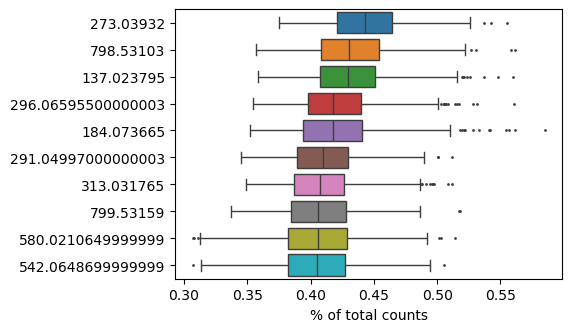

In [23]:
sc.pl.highest_expr_genes(adata_msi, n_top=10)

In [24]:
top_30_metabolites = adata_msi.var.sort_values("total_counts", ascending=False).index[:30]


In [25]:
top_30_metabolites

Index(['273.03932', '798.53103', '137.023795', '296.06595500000003',
       '184.073665', '291.04997000000003', '313.031765', '799.53159',
       '580.0210649999999', '542.0648699999999', '428.03476', '291.048925',
       '274.04288499999996', '290.041915', '617.9799350000001',
       '195.09167000000002', '195.09231', '524.0561849999999', '761.57689',
       '176.00849', '274.041785', '735.566455', '214.01164', '423.9825',
       '465.990335', '313.03045', '409.053895', '820.5117700000001',
       '280.092375', '251.9674'],
      dtype='object')

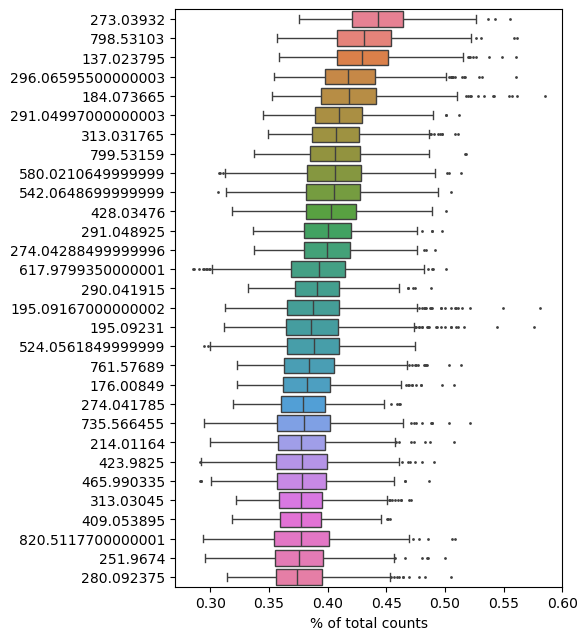

In [27]:
sc.pl.highest_expr_genes(adata_msi, n_top=30)

In [28]:
mz_values = adata_msi.var_names.astype(float).to_numpy()
mz_values

array([137.023795, 154.026815, 162.11294 , 169.07619 , 169.076575,
       170.07992 , 170.0843  , 171.09223 , 176.00807 , 176.00849 ,
       177.01202 , 184.073665, 192.910475, 195.09167 , 195.09231 ,
       196.09551 , 196.099945, 197.990325, 198.089485, 198.997635,
       198.99817 , 198.99861 , 203.05299 , 206.055125, 209.956945,
       213.964855, 214.01164 , 223.03314 , 225.970665, 236.99253 ,
       240.122615, 245.044795, 250.092675, 250.09344 , 251.96655 ,
       251.9674  , 268.104005, 269.107645, 273.03447 , 273.03932 ,
       274.036065, 274.036655, 274.04128 , 274.041785, 274.042885,
       274.04389 , 274.04675 , 275.04461 , 275.045965, 275.054015,
       275.05495 , 275.055885, 275.066305, 280.092375, 282.27948 ,
       287.054975, 289.03455 , 290.04088 , 290.041915, 290.04295 ,
       291.04627 , 291.048925, 291.04997 , 291.975255, 292.053015,
       292.05779 , 293.065595, 295.02107 , 295.022045, 296.065955,
       297.048175, 297.06824 , 297.070615, 298.065095, 299.305

In [29]:
dhb_peaks_positive = np.array([137.0238, 155.0341, 177.0173, 193.0351, 273.0454])
found_peaks = set(mz_values[np.abs(mz_values[:, None] - dhb_peaks_positive[None, :]).min(axis=1) <= 0.1])
found_peaks_str = set(map(str, found_peaks))


In [30]:
found_peaks_str

{'137.023795', '177.01202', '273.03447', '273.03932'}

In [31]:
top_30_metabolites

Index(['273.03932', '798.53103', '137.023795', '296.06595500000003',
       '184.073665', '291.04997000000003', '313.031765', '799.53159',
       '580.0210649999999', '542.0648699999999', '428.03476', '291.048925',
       '274.04288499999996', '290.041915', '617.9799350000001',
       '195.09167000000002', '195.09231', '524.0561849999999', '761.57689',
       '176.00849', '274.041785', '735.566455', '214.01164', '423.9825',
       '465.990335', '313.03045', '409.053895', '820.5117700000001',
       '280.092375', '251.9674'],
      dtype='object')

In [32]:
top_30_filtered = [mz for mz in top_30_metabolites if mz not in found_peaks_str]
top_30_filtered

['798.53103',
 '296.06595500000003',
 '184.073665',
 '291.04997000000003',
 '313.031765',
 '799.53159',
 '580.0210649999999',
 '542.0648699999999',
 '428.03476',
 '291.048925',
 '274.04288499999996',
 '290.041915',
 '617.9799350000001',
 '195.09167000000002',
 '195.09231',
 '524.0561849999999',
 '761.57689',
 '176.00849',
 '274.041785',
 '735.566455',
 '214.01164',
 '423.9825',
 '465.990335',
 '313.03045',
 '409.053895',
 '820.5117700000001',
 '280.092375',
 '251.9674']

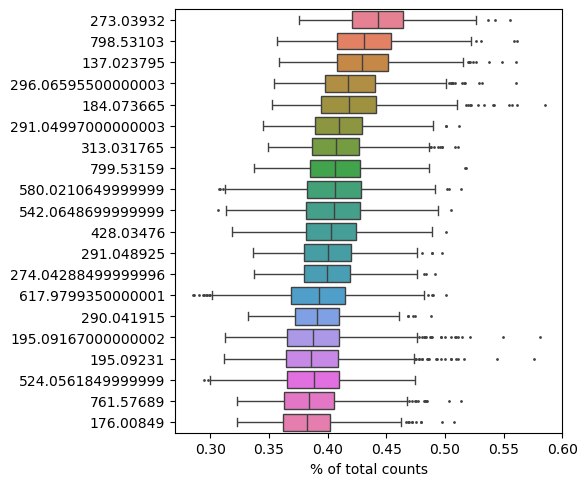

In [34]:
sc.pl.highest_expr_genes(adata_msi, n_top=20)


In [38]:
top_20_metabolites = top_30_filtered[:20]
adata_msi_top20 = adata_msi[:, adata_msi.var_names.isin(top_20_metabolites)].copy()
top_10_metabolites = top_30_filtered[:10]
adata_msi_top10 = adata_msi[:, adata_msi.var_names.isin(top_10_metabolites)].copy()



In [39]:
adata_msi_top20
adata_msi_top10

AnnData object with n_obs × n_vars = 2681 × 10
    obs: 'technology', 'clusters', 'split', 'og_index', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    uns: 'clusters', 'clusters_colors', 'hvg', 'log1p', 'moranI', 'neighbors', 'pca', 'spatial_neighbors', 'umap'
    obsm: 'X_pca', 'X_umap', 'raw_counts', 'spatial', 'spatial_warp'
    varm: 'PCs'
    obsp: 'connectivities', 'distances', 'spatial_connectivities', 'spatial_distances'

In [40]:
# adata_msi_top5.write("/lustre/groups/ml01/workspace/eirini.giannakoulia/msi_ds/V11L12-038_A1.MSI_MOSCOT_paired_hvg_top5abundant.h5ad")
# adata_msi_top20.write("/lustre/groups/ml01/workspace/eirini.giannakoulia/msi_ds/V11L12-038_A1.MSI_MOSCOT_paired_hvg_top20abundant.h5ad")
adata_msi_top10.write("/lustre/groups/ml01/workspace/eirini.giannakoulia/msi_ds/V11L12-038_A1.MSI_MOSCOT_paired_hvg_top10abundant.h5ad")

In [ ]:
# adata_msi_top5.var_names

Index(['184.073665', '291.04997000000003', '296.06595500000003', '313.031765',
       '798.53103'],
      dtype='object')